<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dropout, Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Apply MICE imputer
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [ ]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [ ]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [ ]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ %s Resampled correlation Plot **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, fmt=".2f")
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


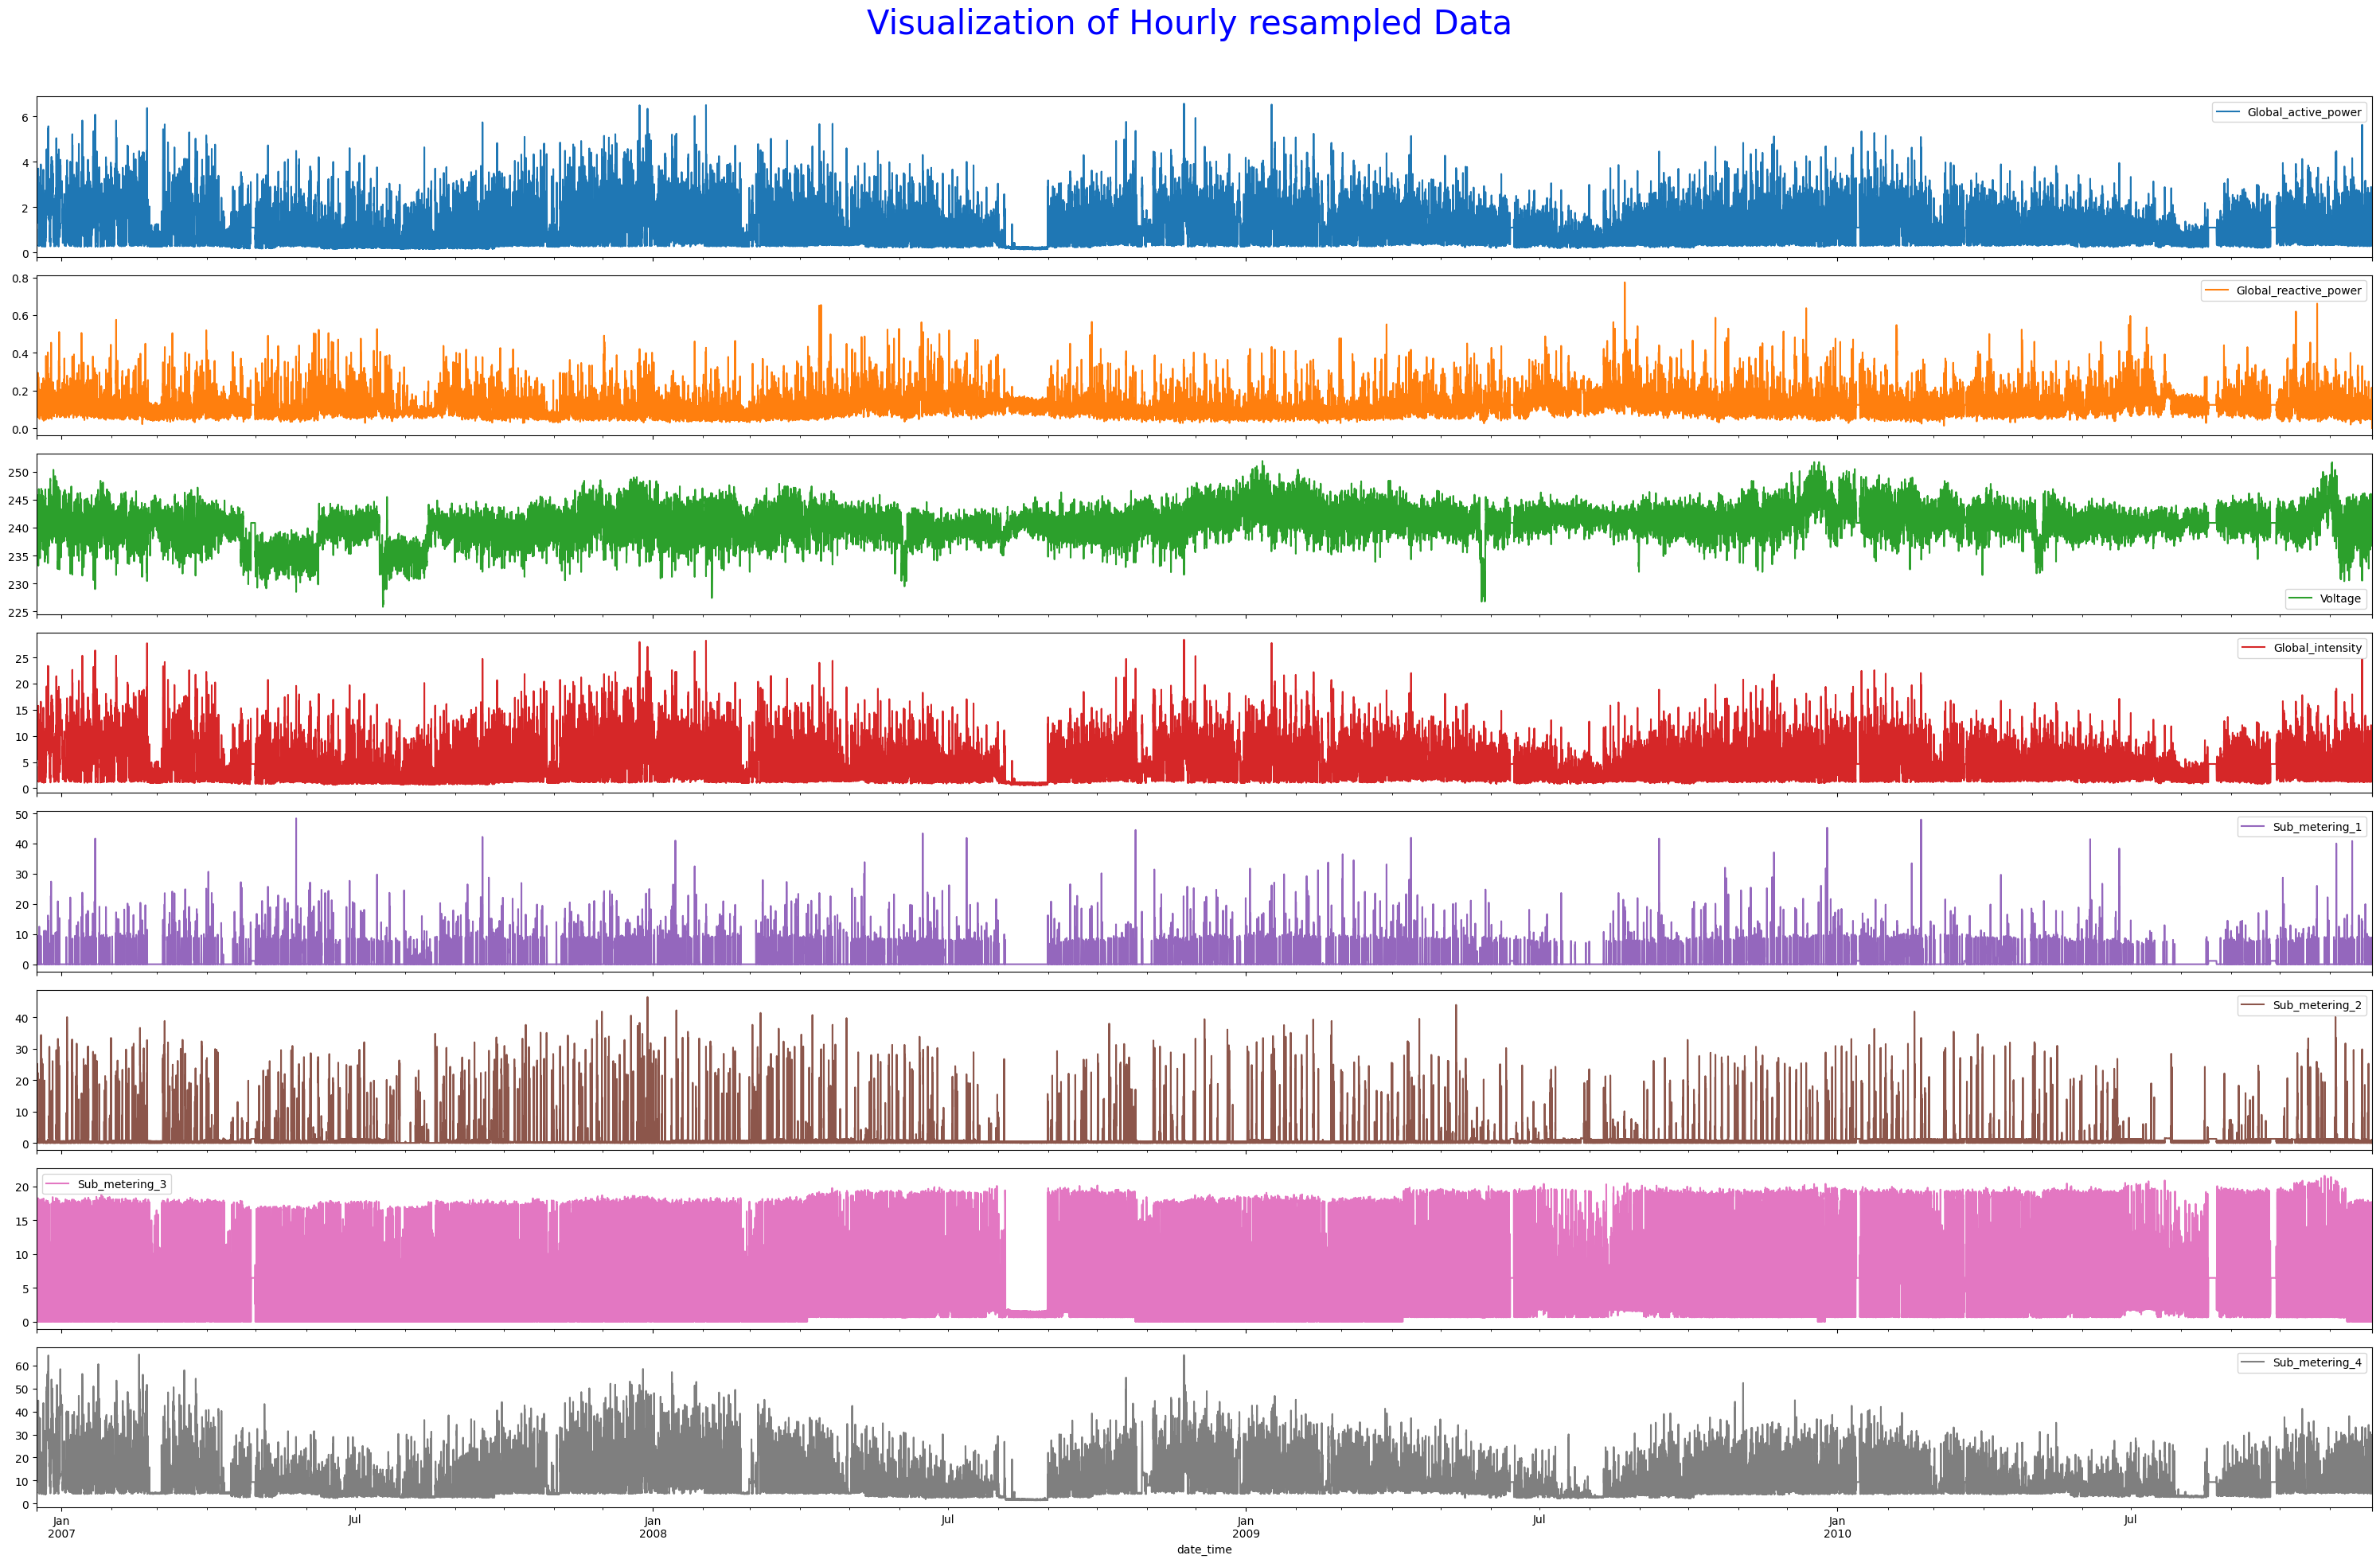

 

************************************************ Hourly Resampled distribution Plot **************************************************



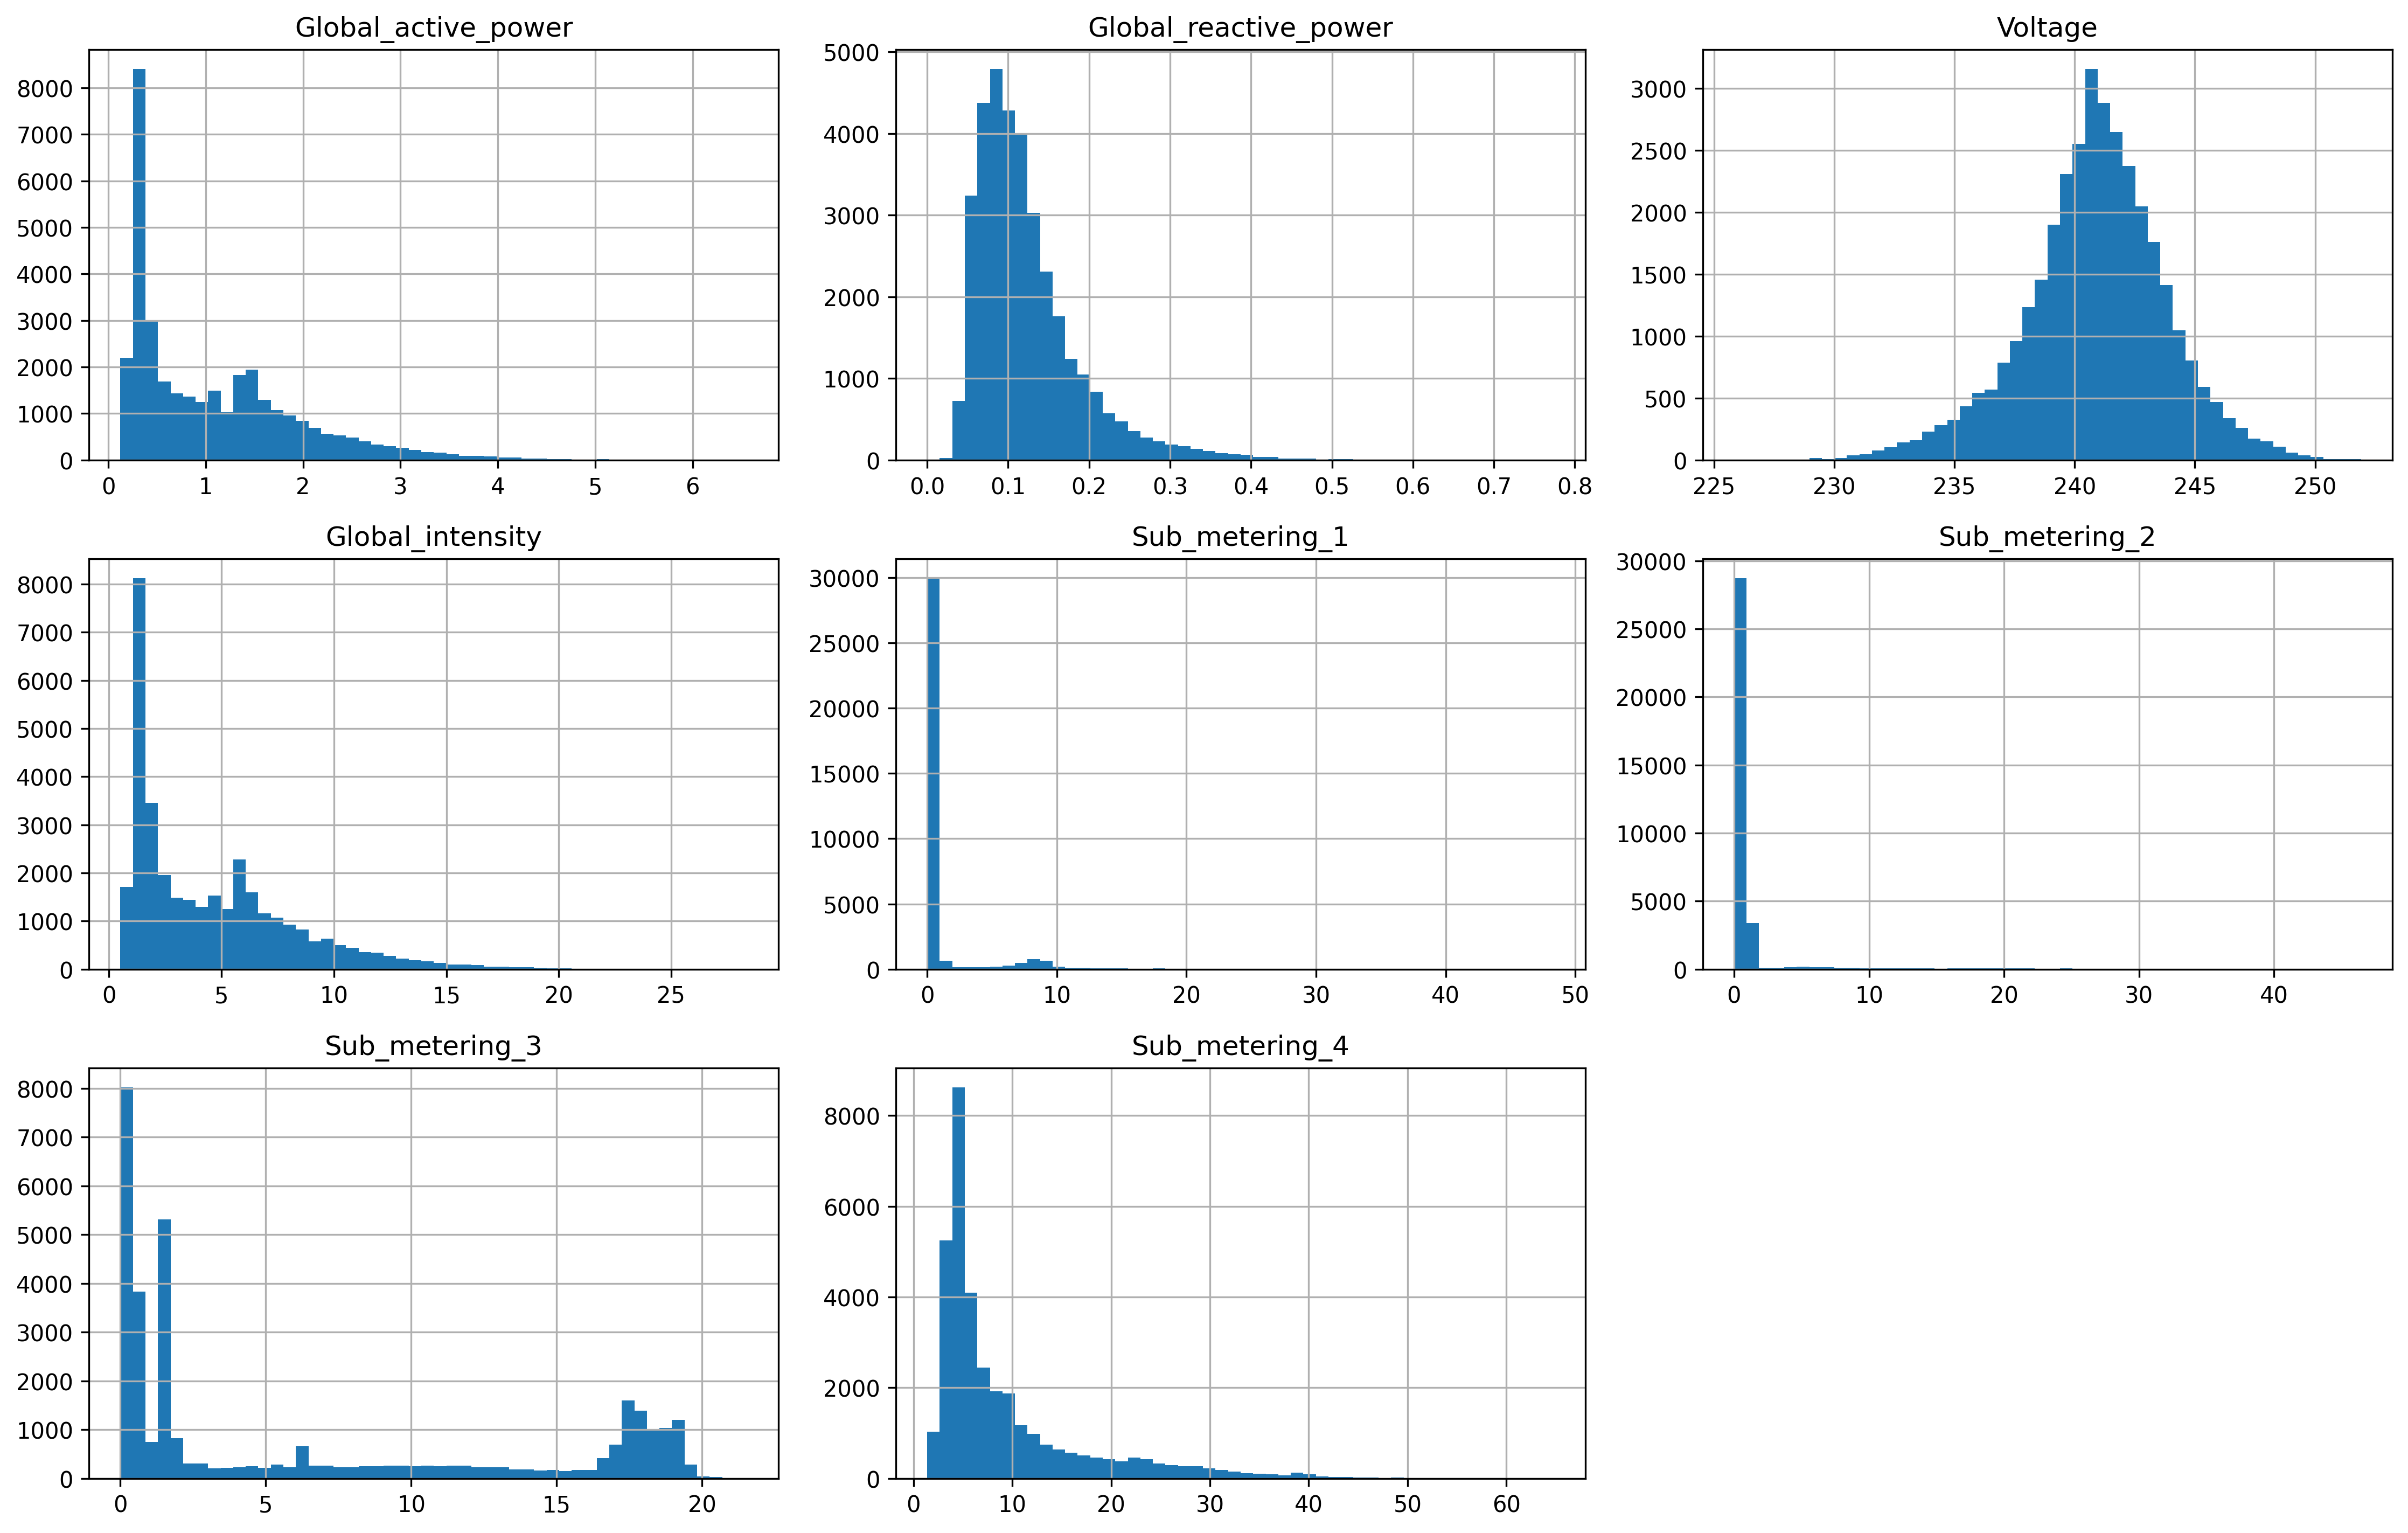

 

************************************************ Hourly Resampled correlation Plot **************************************************



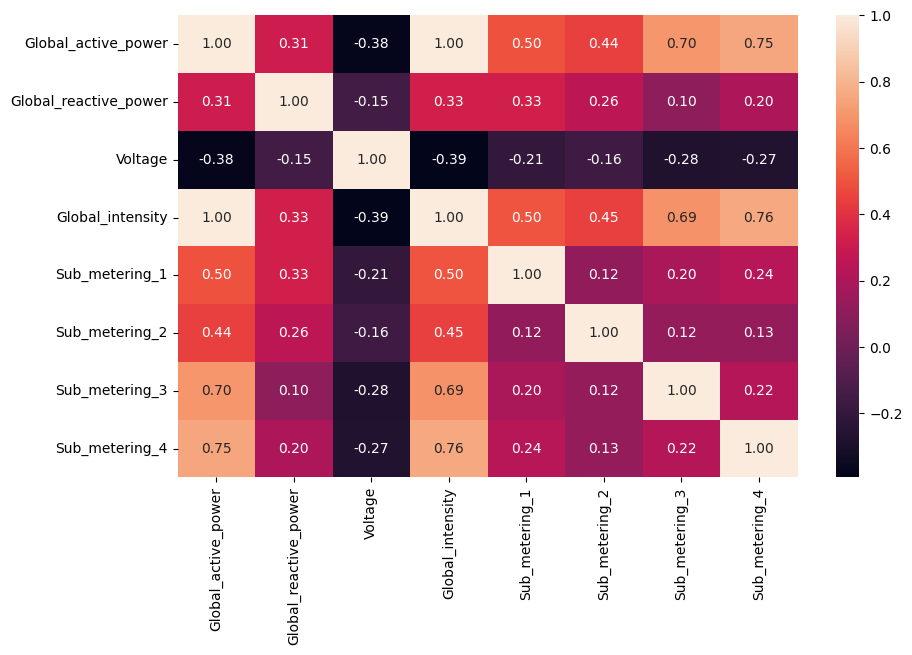

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df, "H", "Hourly")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [ ]:
df1 = hourly_resampled.drop(['Global_intensity'], axis=1)
df1

# Data Normalization

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

In [ ]:
# Shape of scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, 0.        , 0.        ,
        0.        ]])

# Train-Test Splitting

In [ ]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27623, 60, 6), (27623,), (6906, 60, 6), (6906,))

# LSTM model

Define the Model Creation Function

In [ ]:
# Define LSTM model
def create_LSTM_model(optimizer='Adam'):
  model = Sequential()
  model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=64, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=32, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  return model

Set Up Grid Search

In [ ]:
# Create the KerasRegressor
model = KerasRegressor(build_fn=create_LSTM_model, epochs=30, batch_size=32, verbose=1)

# Define the grid of hyperparameters
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'epochs': [50, 100, 200],
    'batch_size': [32, 64, 128]
    }

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)

# Define callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5 , min_delta=0.01)

# Perform the grid search
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping])

Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0174
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0108
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0090
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0082
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0078
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0077
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0074
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0074
Epoch 9/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0074
Epoch 10/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0073
Epoch 11/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0072
Epoch 12/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0071
Epoch 13/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0071
Epoch 14/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0069
Epoch 15/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6

Evaluate the Results

In [ ]:
# Print the best parameters and the best score
print(f'Best parameters: {grid_result.best_params_}')
print(f'Best score: {grid_result.best_score_}')

NameError: name 'grid_result' is not defined

# Fine turning LSTM-1
+ optimizer=Adam
lr=0.1
epochs=50
batch_size=32

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

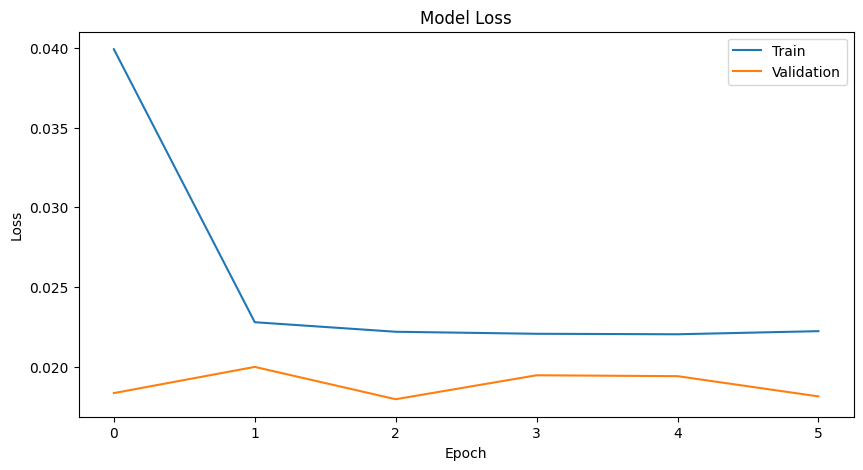

216/216 [==============================] - 1s 5ms/step
Train Mean Absolute Error: 0.7336609737004511
Train Mean Squared Error: 0.8719592926144726
Train Root Mean Squared Error: 0.9337876057297358

Test Mean Absolute Error: 0.5905380318992296
Test Mean Squared Error: 0.5236289325389755
Test Root Mean Squared Error: 0.7236220923513705


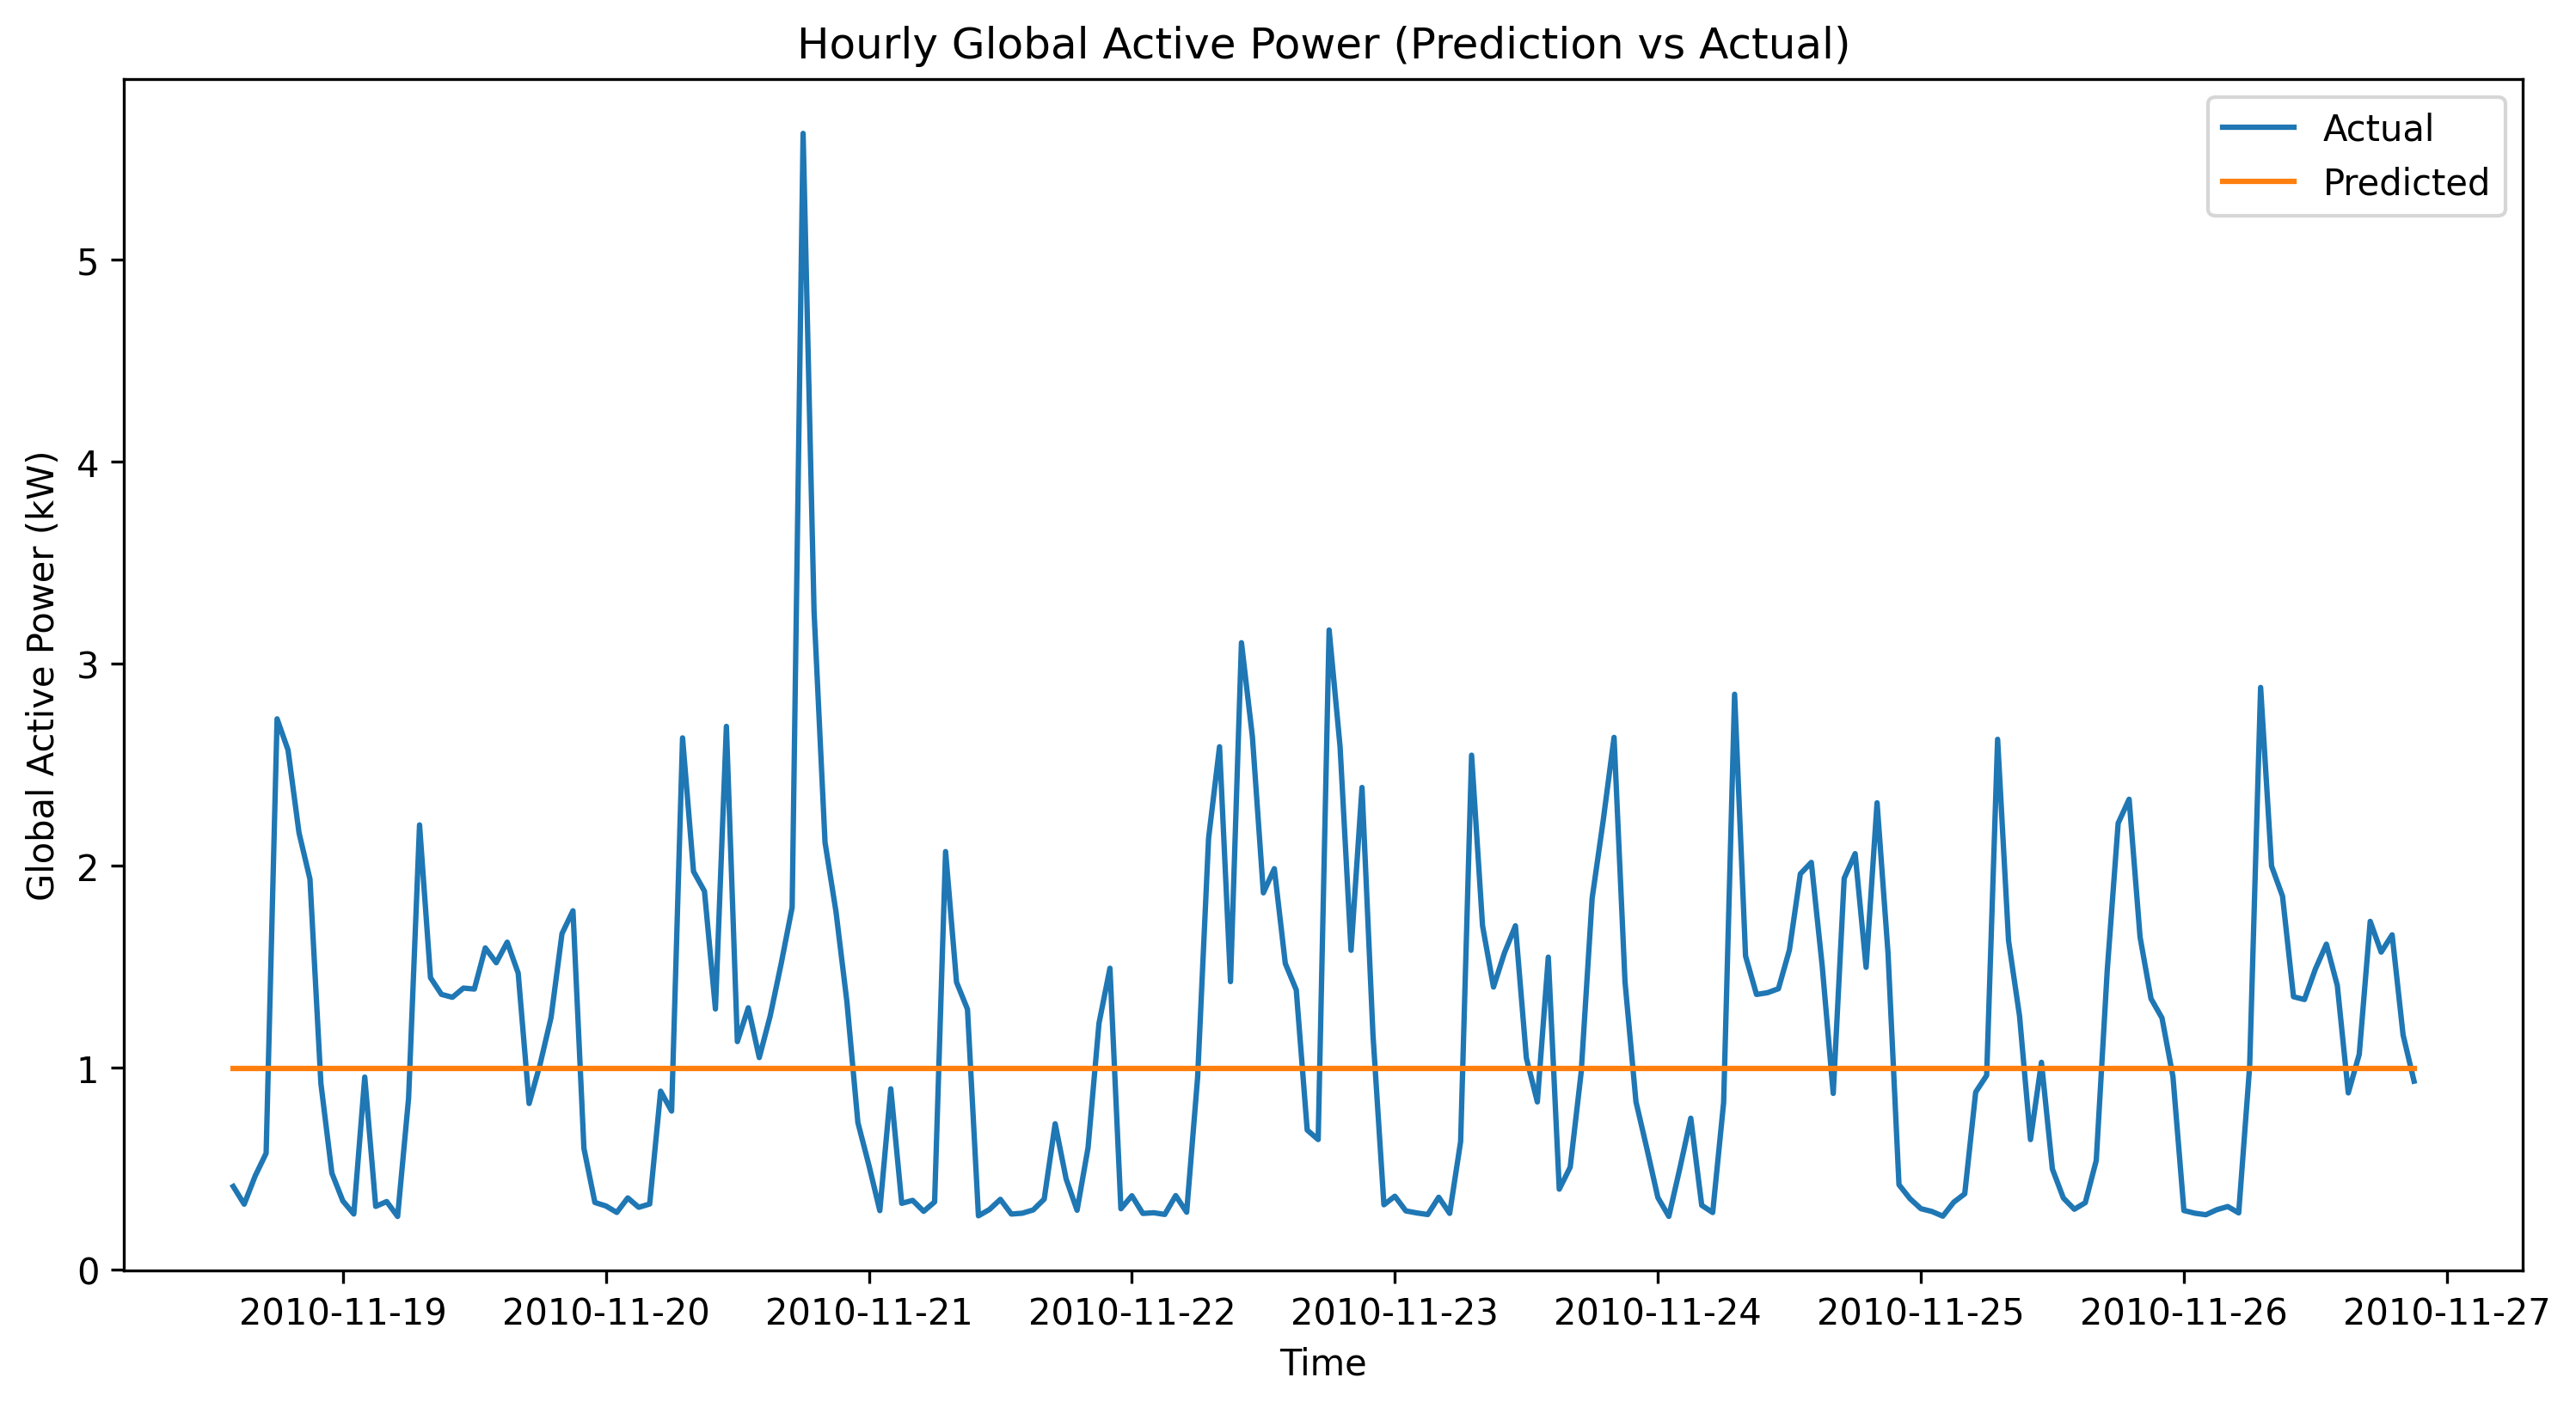

In [ ]:
# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Configure the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.1)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5 , min_delta=0.01)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, 6, axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, 6, axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Fine turning LSTM-1
+ optimizer=Adam
lr=0.01
epochs=50
batch_size=32

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 128)           69120     
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

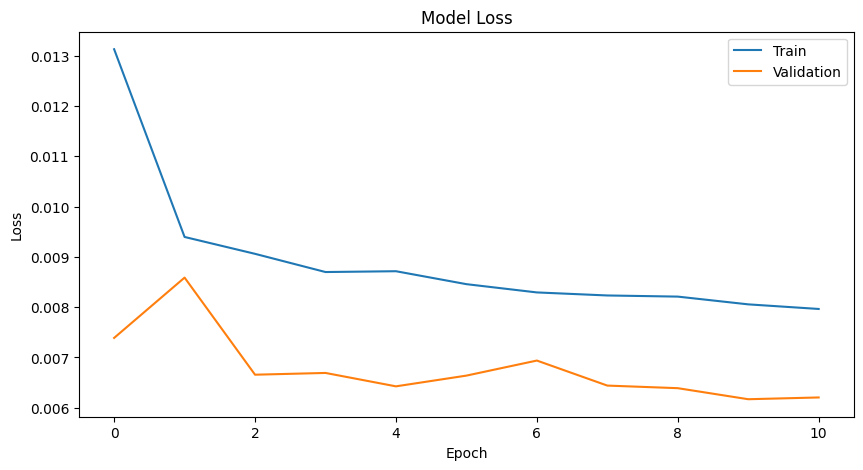

216/216 [==============================] - 1s 6ms/step
Train Mean Absolute Error: 0.37807770671929003
Train Mean Squared Error: 0.2888526817647265
Train Root Mean Squared Error: 0.5374501667733731

Test Mean Absolute Error: 0.34434877831887695
Test Mean Squared Error: 0.22846565884178713
Test Root Mean Squared Error: 0.47798081430302947


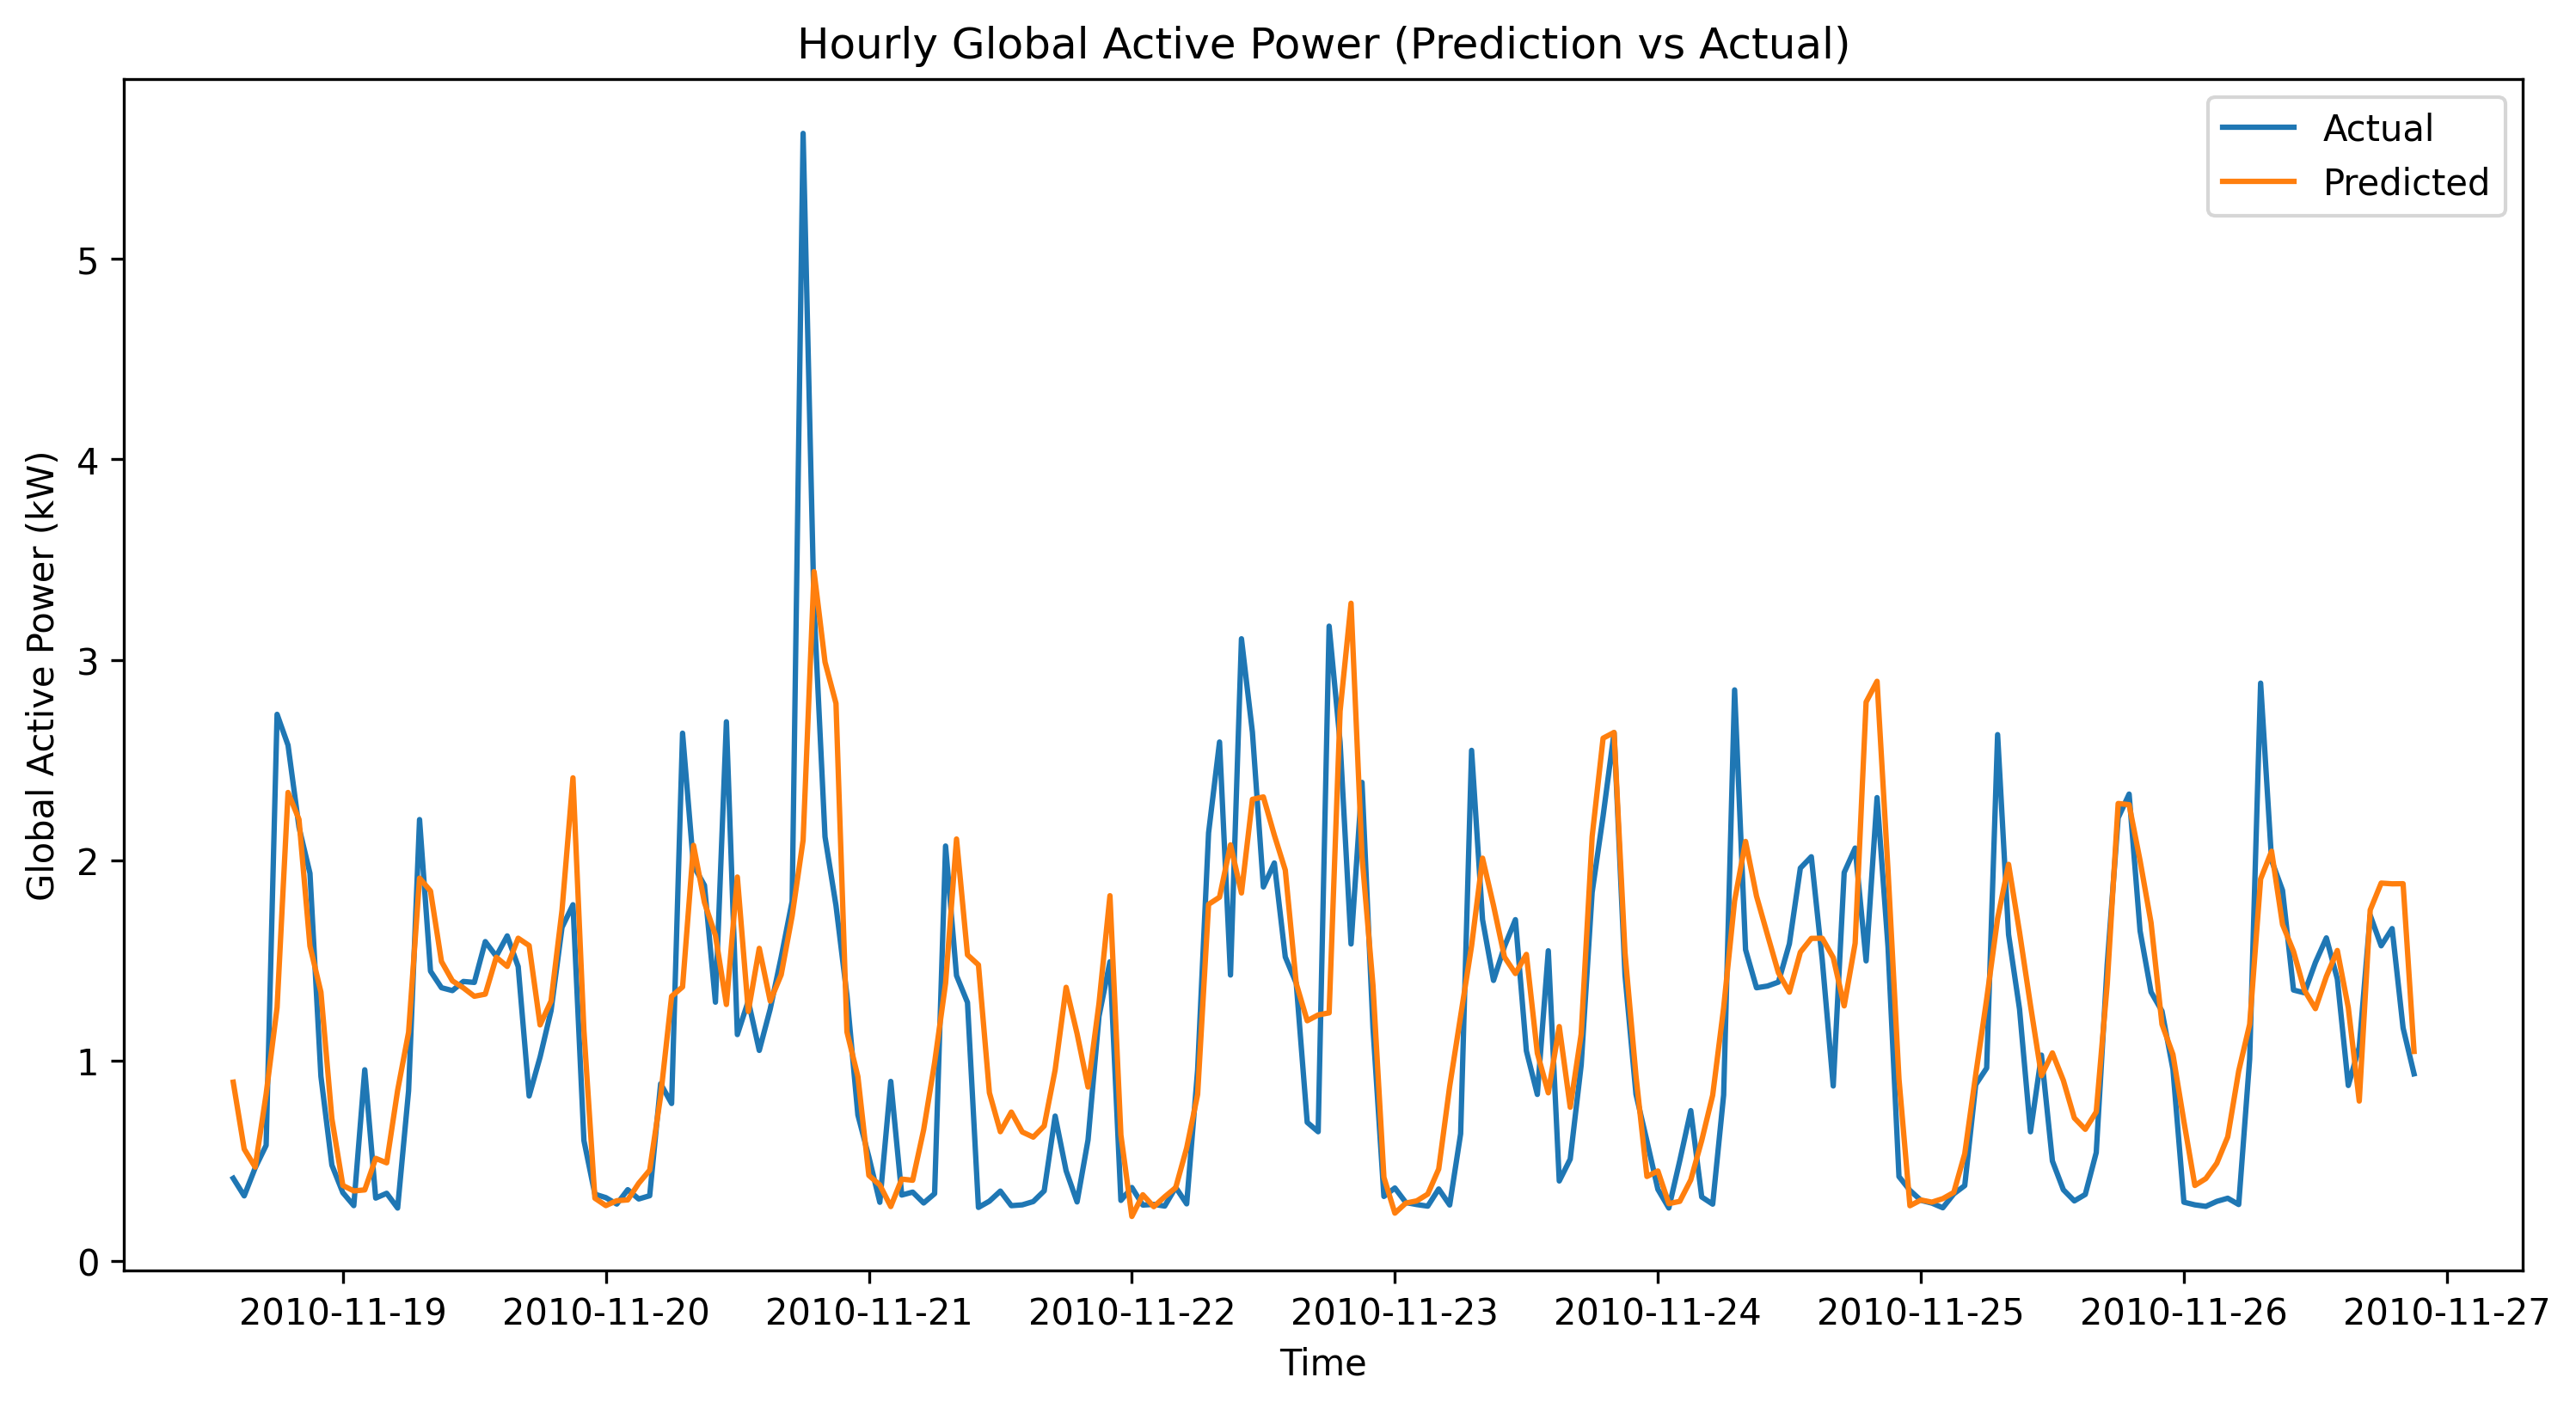

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Configure the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10 , min_delta=0.01)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, 6, axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, 6, axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Fine turning LSTM-3
+ optimizer=Adam lr=0.001 epochs=50 batch_size=32

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           69120     
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_7 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

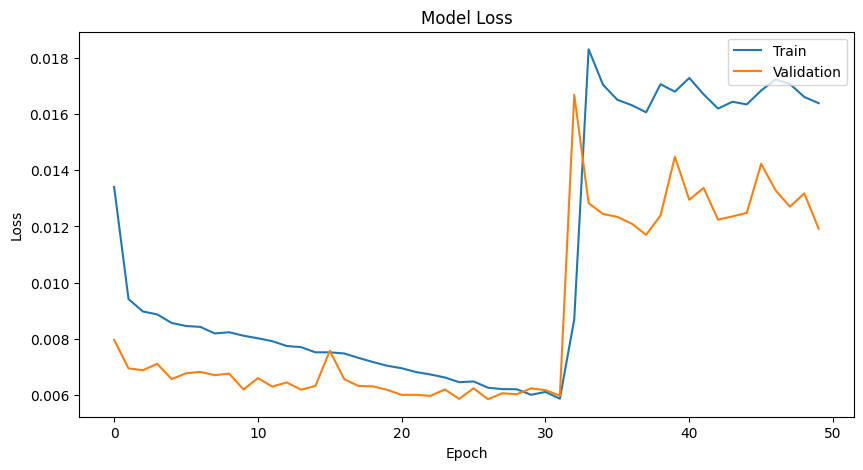

216/216 [==============================] - 1s 4ms/step
Train Mean Absolute Error: 0.5786739774180699
Train Mean Squared Error: 0.5810486458586122
Train Root Mean Squared Error: 0.7622654694124693

Test Mean Absolute Error: 0.48644809892204016
Test Mean Squared Error: 0.38977706394968437
Test Root Mean Squared Error: 0.624321282633937


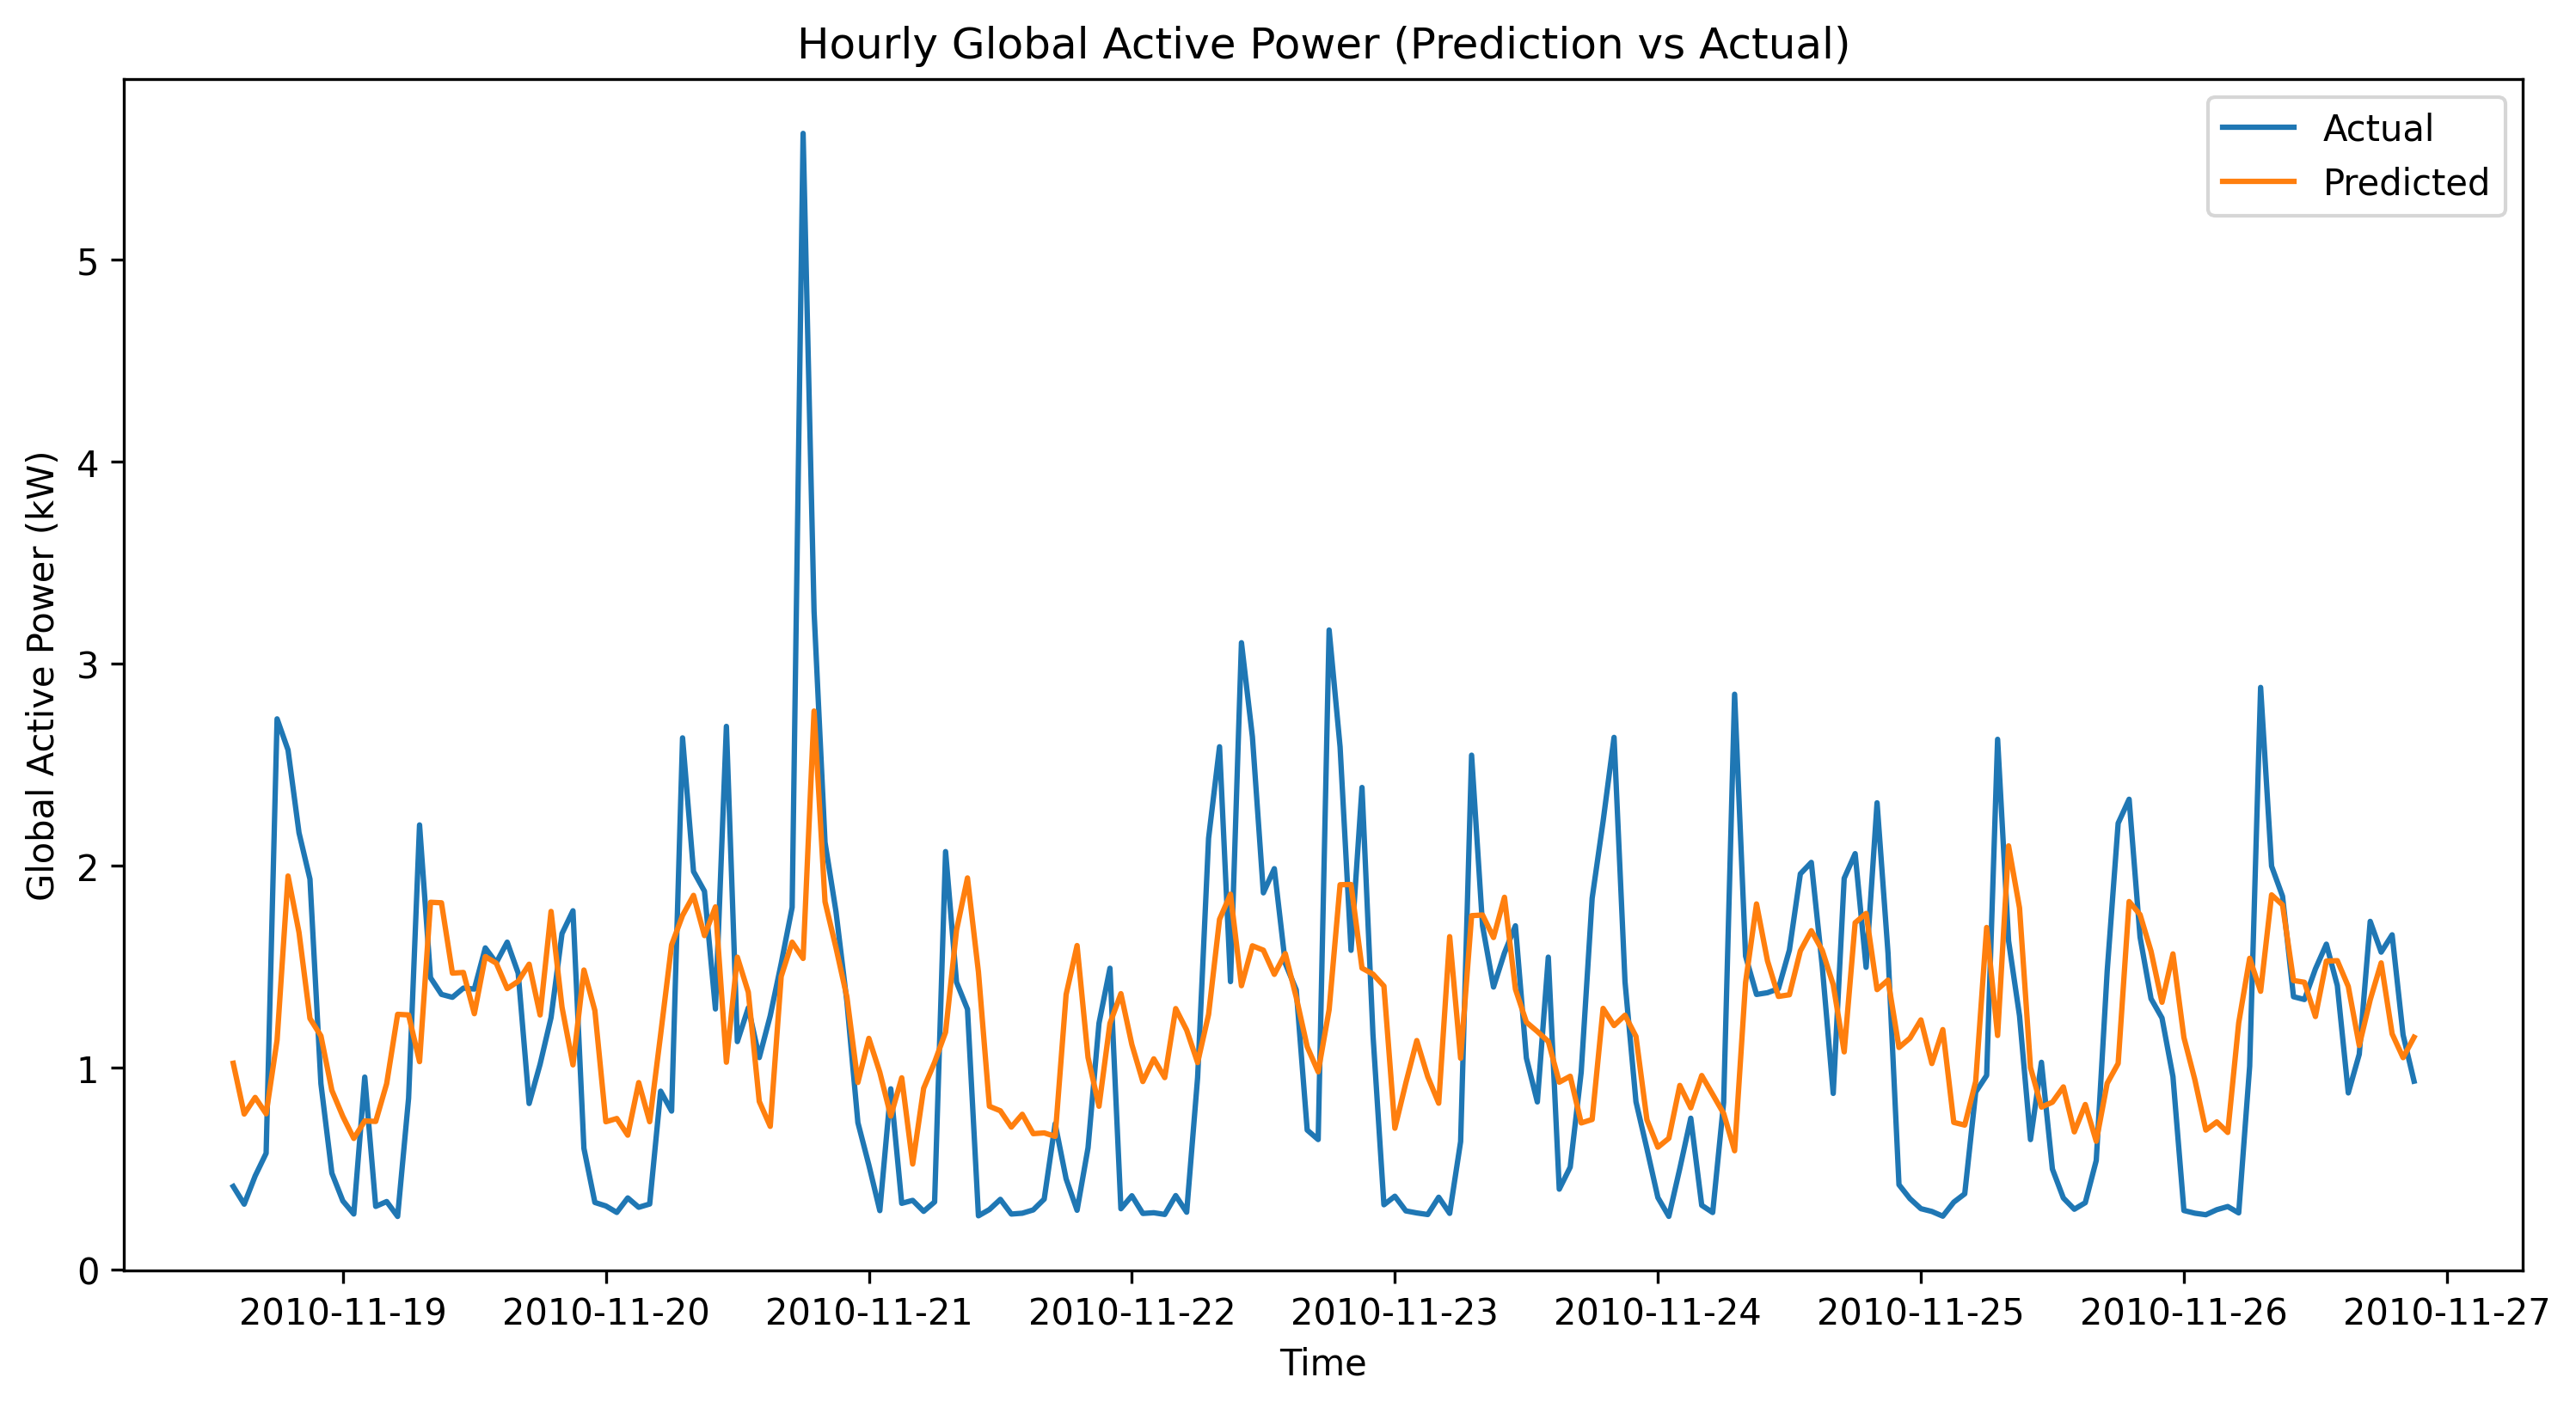

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Configure the optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10 , min_delta=0.01)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, 6, axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, 6, axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train Mean Absolute Error:', mean_absolute_error(true_train_y, pred_train_y))
print('Train Mean Squared Error:', mean_squared_error(true_train_y, pred_train_y))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest Mean Absolute Error:', mean_absolute_error(true_test_y, pred_test_y))
print('Test Mean Squared Error:', mean_squared_error(true_test_y, pred_test_y))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()